In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import zipfile

zip_file_path = "/content/drive/MyDrive/IoT/yujinfeeling.zip"

# ZipFile 객체 생성
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # 압축 파일 푸는 디렉토리 지정하여 압축 해제
    zip_ref.extractall("/content/drive/MyDrive/IoT/data_yujinfeeling")

In [ ]:
import os
import random
import fnmatch
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
print( f'np.__version__: {np.__version__}' )
print( f'pytorch.__version__: {torch.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image


np.__version__: 1.25.2
pytorch.__version__: 2.3.0+cu121


image_path: /content/drive/MyDrive/IoT/data_yujinfeeling/data/_17932_135.png
steering_Angle: 135


Angle
90.0000     19436
45.0000     10465
135.0000    10284
-90.0000     1135
Name: count, dtype: int64

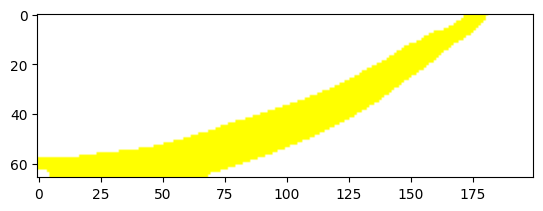

In [ ]:
data_dir = '/content/drive/MyDrive/IoT/data_yujinfeeling/data'
file_list = os.listdir(data_dir)
image_paths = [] #이미지 경로를 저장하는 변수
steering_angles = [] #이미지 각도를 저장하는 변수
pattern = "*.png"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename)) #image_paths 리스트에 파일명을 추가한다.
        angle = float(filename[-7:-4]) #각도는 사진데이터에서 끝의 -7부터 -3까지만 분리한다.
     #예를들어 train_00006_090.png 파일명이라면 090만 분리하여 저장한다. .png도 파일명의 숫자로 포함 된다.
        steering_angles.append(angle) #steering_angles 리스트에 각도를 추가한다.

image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: %d" % steering_angles[image_index] )
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles
angle_counts = df['Angle'].value_counts()

angle_counts

(array([1135.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 10615.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 19337.0000, 0.0000, 0.0000, 0.0000,
        10791.0000]),
 array([-90.0000, -81.0000, -72.0000, -63.0000, -54.0000, -45.0000,
        -36.0000, -27.0000, -18.0000, -9.0000, 0.0000, 9.0000, 18.0000,
        27.0000, 36.0000, 45.0000, 54.0000, 63.0000, 72.0000, 81.0000,
        90.0000, 99.0000, 108.0000, 117.0000, 126.0000, 135.0000]),
 <BarContainer object of 25 artists>)

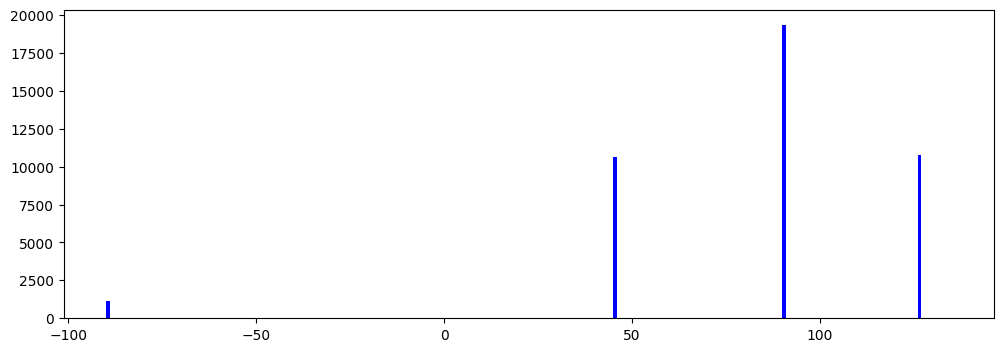

In [ ]:
num_of_bins = 25
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')


Training data: 33056
Validation data: 4132
Test data: 4132


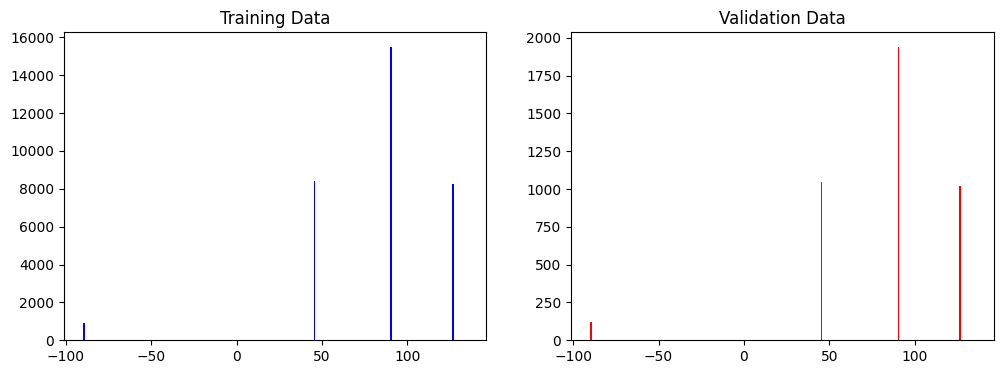

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 데이터 분할 비율
train_ratio = 0.8
valid_ratio = 0.1
test_ratio = 0.1

# 전체 데이터에서 train : test = 0.8 : 0.2 비율로 split
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, steering_angles, test_size=(valid_ratio + test_ratio))

# temp 데이터를 다시 valid : test = 0.5 : 0.5 비율로 split
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

print("Training data: %d\nValidation data: %d\nTest data: %d" % (len(X_train), len(X_valid), len(X_test)))

# 데이터 시각화
num_of_bins = 25  # 히스토그램의 빈 개수 (적절하게 설정)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')
plt.show()


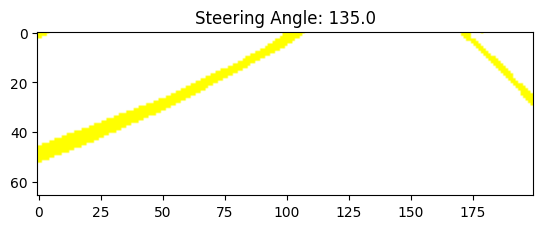

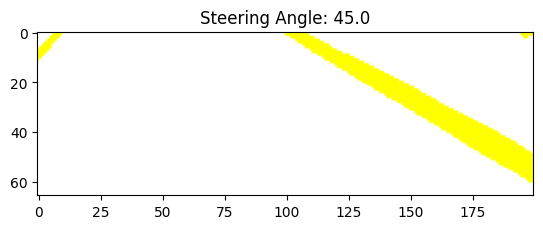

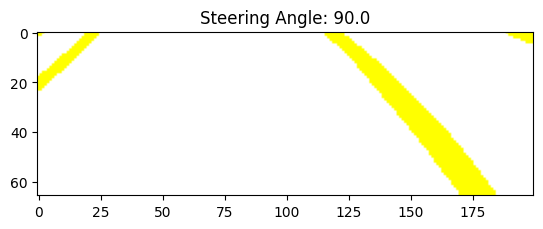

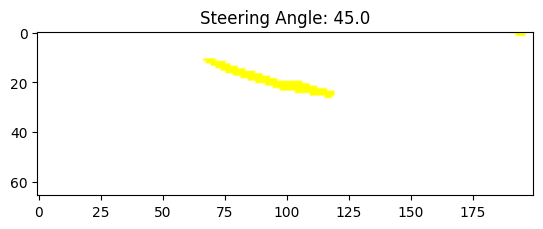

In [ ]:
import gc

transformations = transforms.Compose([
    transforms.Resize((66, 200)),
    transforms.ToTensor()
])
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, steering_angles, transform=None):
        self.image_paths = image_paths
        self.steering_angles = steering_angles
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        steering_angle = self.steering_angles[idx]

        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)

        return image, steering_angle
gc.collect()
torch.cuda.empty_cache()

# 데이터 생성
train_dataset = CustomImageDataset(X_train, y_train, transform=transformations)
valid_dataset = CustomImageDataset(X_valid, y_valid, transform=transformations)
test_dataset = CustomImageDataset(X_test, y_test, transform=transformations)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

images, steering_angles = next(iter(test_loader))
for i in range(4):
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(f"Steering Angle: {steering_angles[i]}")
    plt.show()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
# MobileNet 모델 정의
class MobileNetModel(nn.Module):
    def __init__(self):
        super(MobileNetModel, self).__init__()
        self.mobilenet = mobilenet_v2(pretrained=True)  # Load pretrained MobileNet
        self.fc1 = nn.Linear(1000, 256)  # Adjust output features
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        features = self.mobilenet(x)  # Extract features using MobileNet
        x = torch.relu(self.fc1(features))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x


# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 모델, 손실 함수 및 옵티마이저 초기화
model = MobileNetModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:


# train_loader, valid_loader 및 test_loader가 이미 정의되어 있다고 가정
num_epochs = 13
best_loss = float('inf')
model_output_dir = "/content/drive/MyDrive/IoT"

def initialize_model():
    model = MobileNetModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
    return model, optimizer

model, optimizer = initialize_model()


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)")

    for images, angles in train_loader_tqdm:
        images = images.float().to(device)
        angles = angles.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)  # unsqueeze 필요 없음
        loss = criterion(outputs, angles.unsqueeze(1))  # angles를 unsqueeze 상태 유지
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_loader_tqdm.set_postfix({'Loss': loss.item()})

    train_loss /= len(train_loader.dataset)

    model.eval()
    valid_loss = 0.0
    valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)", leave=False)

    with torch.no_grad():
        for images, angles in valid_loader_tqdm:
            images = images.float().to(device)
            angles = angles.float().to(device)

            outputs = model(images)  # unsqueeze 필요 없음
            loss = criterion(outputs, angles.unsqueeze(1))  # angles를 unsqueeze 상태 유지
            valid_loss += loss.item() * images.size(0)
            valid_loader_tqdm.set_postfix({'Loss': loss.item()})

    valid_loss /= len(valid_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_output_dir, 'lane_yujinfeeling.pth'))
        print("Saved Best Model")

# 모델 평가
model.eval()
test_loss = 0.0
predictions = []
actuals = []
test_loader_tqdm = tqdm(test_loader, desc="Testing")

with torch.no_grad():
    for images, angles in test_loader_tqdm:
        images = images.float().to(device)
        angles = angles.float().to(device)

        outputs = model(images)  # unsqueeze 필요 없음
        loss = criterion(outputs, angles.unsqueeze(1))
        test_loss += loss.item() * images.size(0)
        predictions.extend(outputs.squeeze().tolist())
        actuals.extend(angles.tolist())

print(f'Test Loss: {test_loss/len(test_loader.dataset):.4f}')

Epoch 1/13 (Training): 100%|██████████| 331/331 [08:52<00:00,  1.61s/it, Loss=423]


Epoch [1/13], Train Loss: 796.3200, Validation Loss: 364.9216
Saved Best Model


Epoch 2/13 (Training): 100%|██████████| 331/331 [01:59<00:00,  2.77it/s, Loss=357]


Epoch [2/13], Train Loss: 414.8491, Validation Loss: 359.4727
Saved Best Model


Epoch 3/13 (Training): 100%|██████████| 331/331 [01:59<00:00,  2.77it/s, Loss=343]


Epoch [3/13], Train Loss: 338.0445, Validation Loss: 366.0836


Epoch 4/13 (Training): 100%|██████████| 331/331 [01:59<00:00,  2.77it/s, Loss=428]


Epoch [4/13], Train Loss: 306.0552, Validation Loss: 370.9466


Epoch 5/13 (Training): 100%|██████████| 331/331 [02:00<00:00,  2.75it/s, Loss=292]


Epoch [5/13], Train Loss: 293.6028, Validation Loss: 384.2445


Epoch 6/13 (Training): 100%|██████████| 331/331 [02:00<00:00,  2.75it/s, Loss=486]


Epoch [6/13], Train Loss: 251.1661, Validation Loss: 397.0692


Epoch 7/13 (Training): 100%|██████████| 331/331 [01:59<00:00,  2.76it/s, Loss=252]


Epoch [7/13], Train Loss: 237.3826, Validation Loss: 378.9953


Epoch 8/13 (Training): 100%|██████████| 331/331 [01:59<00:00,  2.77it/s, Loss=191]


Epoch [8/13], Train Loss: 219.8134, Validation Loss: 232.8204
Saved Best Model


Epoch 9/13 (Training): 100%|██████████| 331/331 [01:59<00:00,  2.78it/s, Loss=160]


Epoch [9/13], Train Loss: 197.9645, Validation Loss: 221.1057
Saved Best Model


Epoch 10/13 (Training): 100%|██████████| 331/331 [01:58<00:00,  2.80it/s, Loss=163]


Epoch [10/13], Train Loss: 184.7533, Validation Loss: 196.1027
Saved Best Model


Epoch 11/13 (Training): 100%|██████████| 331/331 [01:58<00:00,  2.78it/s, Loss=54.9]


Epoch [11/13], Train Loss: 167.3981, Validation Loss: 178.6692
Saved Best Model


Epoch 12/13 (Training): 100%|██████████| 331/331 [01:58<00:00,  2.80it/s, Loss=208]


Epoch [12/13], Train Loss: 152.1074, Validation Loss: 207.4258


Epoch 13/13 (Training): 100%|██████████| 331/331 [01:59<00:00,  2.77it/s, Loss=168]


Epoch [13/13], Train Loss: 141.0657, Validation Loss: 166.0208
Saved Best Model


Testing: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]

Test Loss: 177.6773


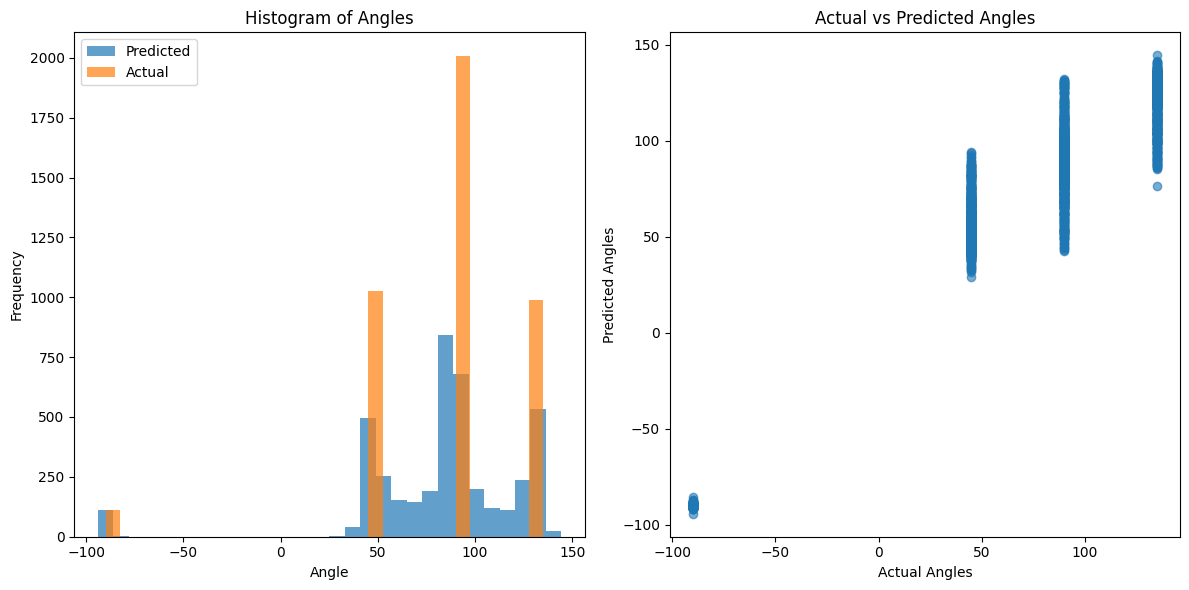

In [ ]:
# 결과 분포를 확인하는 코드 추가
plt.figure(figsize=(12, 6))

# 예측 각도의 히스토그램
plt.subplot(1, 2, 1)
plt.hist(predictions, bins=30, alpha=0.7, label='Predicted')
plt.hist(actuals, bins=30, alpha=0.7, label='Actual')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Angles')

# 실제 각도와 예측 각도의 산포도
plt.subplot(1, 2, 2)
plt.scatter(actuals, predictions, alpha=0.6)
plt.xlabel('Actual Angles')
plt.ylabel('Predicted Angles')
plt.title('Actual vs Predicted Angles')

plt.tight_layout()
plt.show()